<a href="https://colab.research.google.com/github/RoozbehSanaei/deep-learning-notebooks/blob/master/pytorch_fcn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import random

def generate_random_data(height, width, count):
    x, y = zip(*[generate_img_and_mask(height, width) for i in range(0, count)])

    X = np.asarray(x) * 255
    X = X.repeat(3, axis=1).transpose([0, 2, 3, 1]).astype(np.uint8)
    Y = np.asarray(y)

    return X, Y

def generate_img_and_mask(height, width):
    shape = (height, width)

    triangle_location = get_random_location(*shape)
    circle_location1 = get_random_location(*shape, zoom=0.7)
    circle_location2 = get_random_location(*shape, zoom=0.5)
    mesh_location = get_random_location(*shape)
    square_location = get_random_location(*shape, zoom=0.8)
    plus_location = get_random_location(*shape, zoom=1.2)

    # Create input image
    arr = np.zeros(shape, dtype=bool)
    arr = add_triangle(arr, *triangle_location)
    arr = add_circle(arr, *circle_location1)
    arr = add_circle(arr, *circle_location2, fill=True)
    arr = add_mesh_square(arr, *mesh_location)
    arr = add_filled_square(arr, *square_location)
    arr = add_plus(arr, *plus_location)
    arr = np.reshape(arr, (1, height, width)).astype(np.float32)

    # Create target masks
    masks = np.asarray([
        add_filled_square(np.zeros(shape, dtype=bool), *square_location),
        add_circle(np.zeros(shape, dtype=bool), *circle_location2, fill=True),
        add_triangle(np.zeros(shape, dtype=bool), *triangle_location),
        add_circle(np.zeros(shape, dtype=bool), *circle_location1),
         add_filled_square(np.zeros(shape, dtype=bool), *mesh_location),
        # add_mesh_square(np.zeros(shape, dtype=bool), *mesh_location),
        add_plus(np.zeros(shape, dtype=bool), *plus_location)
    ]).astype(np.float32)

    return arr, masks

def add_square(arr, x, y, size):
    s = int(size / 2)
    arr[x-s,y-s:y+s] = True
    arr[x+s,y-s:y+s] = True
    arr[x-s:x+s,y-s] = True
    arr[x-s:x+s,y+s] = True

    return arr

def add_filled_square(arr, x, y, size):
    s = int(size / 2)

    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]

    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, yy > y - s, yy < y + s]))

def logical_and(arrays):
    new_array = np.ones(arrays[0].shape, dtype=bool)
    for a in arrays:
        new_array = np.logical_and(new_array, a)

    return new_array

def add_mesh_square(arr, x, y, size):
    s = int(size / 2)

    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]

    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, xx % 2 == 1, yy > y - s, yy < y + s, yy % 2 == 1]))

def add_triangle(arr, x, y, size):
    s = int(size / 2)

    triangle = np.tril(np.ones((size, size), dtype=bool))

    arr[x-s:x-s+triangle.shape[0],y-s:y-s+triangle.shape[1]] = triangle

    return arr

def add_circle(arr, x, y, size, fill=False):
    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]
    circle = np.sqrt((xx - x) ** 2 + (yy - y) ** 2)
    new_arr = np.logical_or(arr, np.logical_and(circle < size, circle >= size * 0.7 if not fill else True))

    return new_arr

def add_plus(arr, x, y, size):
    s = int(size / 2)
    arr[x-1:x+1,y-s:y+s] = True
    arr[x-s:x+s,y-1:y+1] = True

    return arr

def get_random_location(width, height, zoom=1.0):
    x = int(width * random.uniform(0.1, 0.9))
    y = int(height * random.uniform(0.1, 0.9))

    size = int(min(width, height) * random.uniform(0.06, 0.12) * zoom)

    return (x, y, size)

import matplotlib.pyplot as plt
import numpy as np

def plot_img_array(img_array, ncol=3):
    nrow = len(img_array) // ncol

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))

    for i in range(len(img_array)):
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(img_array[i])

from functools import reduce
def plot_side_by_side(img_arrays):
    flatten_list = reduce(lambda x,y: x+y, zip(*img_arrays))

    plot_img_array(np.array(flatten_list), ncol=len(img_arrays))

import itertools
def plot_errors(results_dict, title):
    markers = itertools.cycle(('+', 'x', 'o'))

    plt.title('{}'.format(title))

    for label, result in sorted(results_dict.items()):
        plt.plot(result, marker=next(markers), label=label)
        plt.ylabel('dice_coef')
        plt.xlabel('epoch')
        plt.legend(loc=3, bbox_to_anchor=(1, 0))

    plt.show()

def masks_to_colorimg(masks):
    colors = np.asarray([(201, 58, 64), (242, 207, 1), (0, 152, 75), (101, 172, 228),(56, 34, 132), (160, 194, 56)])

    colorimg = np.ones((masks.shape[1], masks.shape[2], 3), dtype=np.float32) * 255
    channels, height, width = masks.shape

    for y in range(height):
        for x in range(width):
            selected_colors = colors[masks[:,y,x] > 0.5]

            if len(selected_colors) > 0:
                colorimg[y,x,:] = np.mean(selected_colors, axis=0)

    return colorimg.astype(np.uint8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(3, 192, 192, 3)
0 255
(3, 6, 192, 192)
0.0 1.0


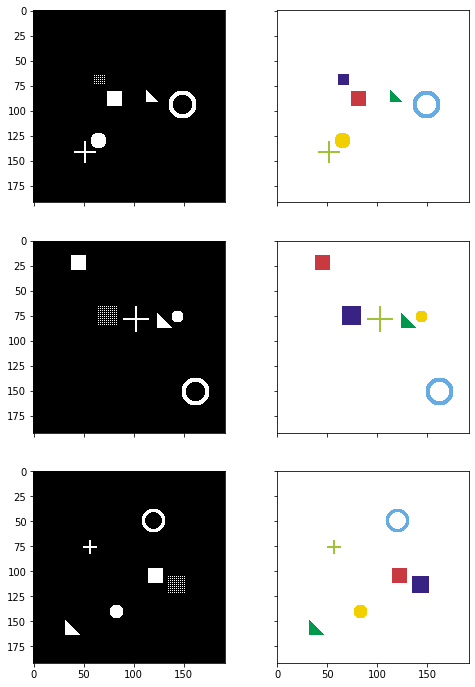

In [0]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import helper

# Generate some random images
input_images, target_masks = generate_random_data(192, 192, count=3)

for x in [input_images, target_masks]:
    print(x.shape)
    print(x.min(), x.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [masks_to_colorimg(x) for x in target_masks]

# Left: Input image, Right: Target mask (Ground-truth)
plot_side_by_side([input_images_rgb, target_masks_rgb])

In [0]:
from torchvision import models

base_model = models.resnet18(pretrained=True)

def find_last_layer(layer):
    children = list(layer.children())
    if len(children) == 0:
        return layer
    else:
        return find_last_layer(children[-1])
    
list(base_model.children())

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 28.4MB/s]


[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [0]:
from torch import nn

model_wo_avgpool = nn.Sequential(*list(base_model.children())[:-2])

#OrderedDict(model_wo_avgpool.named_children())

In [0]:
import torch

class FCN(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        layers = list(base_model.children())
        self.layer1 = nn.Sequential(*layers[:5]) # size=(N, 64, x.H/2, x.W/2)
        self.upsample1 = nn.Upsample(scale_factor=4, mode='bilinear')
        self.layer2 = layers[5]  # size=(N, 128, x.H/4, x.W/4)
        self.upsample2 = nn.Upsample(scale_factor=8, mode='bilinear')
        self.layer3 = layers[6]  # size=(N, 256, x.H/8, x.W/8)
        self.upsample3 = nn.Upsample(scale_factor=16, mode='bilinear')
        self.layer4 = layers[7]  # size=(N, 512, x.H/16, x.W/16)
        self.upsample4 = nn.Upsample(scale_factor=32, mode='bilinear')
        
        self.conv1k = nn.Conv2d(64 + 128 + 256 + 512, n_class, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.layer1(x)
        up1 = self.upsample1(x)
        x = self.layer2(x)
        up2 = self.upsample2(x)
        x = self.layer3(x)
        up3 = self.upsample3(x)
        x = self.layer4(x)
        up4 = self.upsample4(x)
        
        merge = torch.cat([up1, up2, up3, up4], dim=1)
        merge = self.conv1k(merge)
        out = self.sigmoid(merge)
        
        return out

fcn_model = FCN(6)

import torchsummary

#torchsummary.summary(fcn_model, input_size=(3, 224, 224), device='cpu')

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            batch_size = 10
            epoch_steps = 10
            for i in range(epoch_steps):
                input_images, target_masks = generate_random_data(192, 192, count=batch_size)

                inputs = torch.from_numpy(input_images)
                labels = torch.from_numpy(target_masks)
                inputs = inputs.to(device)
                labels = labels.to(device)                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / (batch_size * epoch_steps)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = FCN(6).to(device)

criterion = nn.BCELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


RuntimeError: ignored